In [32]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.decomposition import PCA
from catboost import CatBoostClassifier

In [48]:
current_dir = os.getcwd()

parent_dir = os.path.abspath(os.path.join(current_dir, "../.."))
folder_path = 'data'
file_name = 'train_stroke_woe.csv'

file_path = os.path.join(parent_dir, folder_path, file_name)

df = pd.read_csv(file_path)
df.head()

,gender,hypertension,heart_disease,ever_married,work_type,Residence_type,smoking_status,stroke,bmi_category,age_category,glucose_level_category
0,0,0,0,0,0.059265,1,-0.249627,0,-0.543404,-3.922206,0.921024
1,0,0,0,1,0.059265,1,0.062398,0,0.176297,-3.922206,-0.301429
2,1,0,0,1,0.033575,0,0.062398,1,0.176297,-0.367003,-0.301429
3,0,0,0,0,-2.952380,0,-0.249627,0,-2.816305,-3.068490,-0.301429
4,0,1,0,1,0.059265,0,0.559182,0,0.176297,1.069885,-0.301429


In [49]:
y = df['stroke']
X = df.drop(['stroke'], axis = 1).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 1337)

eval_set = [(X_train, y_train), (X_test, y_test)]

In [50]:
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 3, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-5, 100, log=True),
        'border_count': trial.suggest_int('border_count', 1, 255),
        'random_seed': 42,
        'verbose': 0
    }

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1337)
    accuracies = []

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
        class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

        model = CatBoostClassifier(**params, class_weights = class_weights_dict)
        model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=0)
    
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
    
    return sum(accuracies) / len(accuracies)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

best_params = study.best_params

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

final_model = CatBoostClassifier(**best_params, class_weights = class_weights_dict)
final_model.fit(X, y)

[I 2024-10-10 13:49:04,460] A new study created in memory with name: no-name-fb193e1a-ed7a-461a-bd1e-bc6b9db35e68
[I 2024-10-10 13:49:08,659] Trial 0 finished with value: 0.731924049355939 and parameters: {'iterations': 760, 'learning_rate': 0.04496511954167514, 'depth': 5, 'l2_leaf_reg': 2.2786100019868586e-05, 'border_count': 55}. Best is trial 0 with value: 0.731924049355939.
[I 2024-10-10 13:49:13,244] Trial 1 finished with value: 0.7299162058725245 and parameters: {'iterations': 503, 'learning_rate': 0.20183464180888983, 'depth': 8, 'l2_leaf_reg': 0.0022108241096173917, 'border_count': 92}. Best is trial 0 with value: 0.731924049355939.
[I 2024-10-10 13:49:17,441] Trial 2 finished with value: 0.732424985656009 and parameters: {'iterations': 715, 'learning_rate': 0.1694606041038763, 'depth': 6, 'l2_leaf_reg': 0.0008242101189822977, 'border_count': 188}. Best is trial 2 with value: 0.732424985656009.
[I 2024-10-10 13:49:31,944] Trial 3 finished with value: 0.7271571155652794 and par

0:	learn: 0.5955720	total: 1.52ms	remaining: 627ms
1:	learn: 0.5739761	total: 2.79ms	remaining: 575ms
2:	learn: 0.5614256	total: 3.71ms	remaining: 509ms
3:	learn: 0.5339376	total: 5.22ms	remaining: 535ms
4:	learn: 0.5224209	total: 6.79ms	remaining: 555ms
5:	learn: 0.5175345	total: 7.81ms	remaining: 531ms
6:	learn: 0.5135961	total: 8.84ms	remaining: 514ms
7:	learn: 0.5101125	total: 10.2ms	remaining: 517ms
8:	learn: 0.5082198	total: 11.2ms	remaining: 504ms
9:	learn: 0.5063654	total: 12.4ms	remaining: 501ms
10:	learn: 0.4929892	total: 14.6ms	remaining: 536ms
11:	learn: 0.4922508	total: 15.9ms	remaining: 532ms
12:	learn: 0.4909963	total: 17.7ms	remaining: 547ms
13:	learn: 0.4899451	total: 19ms	remaining: 543ms
14:	learn: 0.4883315	total: 20.5ms	remaining: 546ms
15:	learn: 0.4880616	total: 21.8ms	remaining: 542ms
16:	learn: 0.4878640	total: 23ms	remaining: 536ms
17:	learn: 0.4878312	total: 23.8ms	remaining: 524ms
18:	learn: 0.4875674	total: 25.3ms	remaining: 527ms
19:	learn: 0.4867513	total

In [51]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}
final_model = CatBoostClassifier(**best_params, class_weights = class_weights_dict)
final_model.fit(X, y)

0:	learn: 0.5956605	total: 1.56ms	remaining: 645ms
1:	learn: 0.5674348	total: 2.88ms	remaining: 593ms
2:	learn: 0.5552874	total: 3.83ms	remaining: 524ms
3:	learn: 0.5359986	total: 5.19ms	remaining: 532ms
4:	learn: 0.5284293	total: 6.21ms	remaining: 508ms
5:	learn: 0.5211575	total: 7.58ms	remaining: 516ms
6:	learn: 0.5040882	total: 9.95ms	remaining: 579ms
7:	learn: 0.4999988	total: 11.7ms	remaining: 595ms
8:	learn: 0.4984511	total: 12.8ms	remaining: 575ms
9:	learn: 0.4975557	total: 13.7ms	remaining: 555ms
10:	learn: 0.4880759	total: 16.8ms	remaining: 615ms
11:	learn: 0.4873480	total: 17.9ms	remaining: 600ms
12:	learn: 0.4866198	total: 19.1ms	remaining: 590ms
13:	learn: 0.4858023	total: 20.6ms	remaining: 590ms
14:	learn: 0.4854905	total: 21.9ms	remaining: 582ms
15:	learn: 0.4840846	total: 23.2ms	remaining: 578ms
16:	learn: 0.4840396	total: 24.2ms	remaining: 565ms
17:	learn: 0.4837851	total: 25.7ms	remaining: 565ms
18:	learn: 0.4832696	total: 27.2ms	remaining: 566ms
19:	learn: 0.4829439	t

In [52]:
y_pred_final = final_model.predict(X_test)
accuracy_final = accuracy_score(y_test, y_pred_final)

cv_scores = cross_val_score(final_model, X, y, cv=5)
print(f"Puntajes de validación cruzada: {cv_scores}")
print(f"Media de los puntajes: {cv_scores.mean()}")

conf_matrix = confusion_matrix(y_test, y_pred_final)
class_report = classification_report(y_test, y_pred_final)

0:	learn: 0.5962484	total: 1.36ms	remaining: 564ms
1:	learn: 0.5518023	total: 2.65ms	remaining: 546ms
2:	learn: 0.5424497	total: 3.44ms	remaining: 472ms
3:	learn: 0.5334731	total: 4.49ms	remaining: 460ms
4:	learn: 0.5288110	total: 5.23ms	remaining: 428ms
5:	learn: 0.5148653	total: 6.53ms	remaining: 444ms
6:	learn: 0.5119299	total: 7.35ms	remaining: 427ms
7:	learn: 0.5093992	total: 8.37ms	remaining: 425ms
8:	learn: 0.5067336	total: 9.39ms	remaining: 423ms
9:	learn: 0.5053536	total: 10.7ms	remaining: 432ms
10:	learn: 0.5048184	total: 11.7ms	remaining: 427ms
11:	learn: 0.4913929	total: 14.1ms	remaining: 474ms
12:	learn: 0.4907694	total: 15.4ms	remaining: 474ms
13:	learn: 0.4884776	total: 16.8ms	remaining: 480ms
14:	learn: 0.4883064	total: 17.6ms	remaining: 469ms
15:	learn: 0.4881840	total: 18.6ms	remaining: 464ms
16:	learn: 0.4877669	total: 19.9ms	remaining: 465ms
17:	learn: 0.4877247	total: 21.2ms	remaining: 465ms
18:	learn: 0.4876702	total: 22ms	remaining: 458ms
19:	learn: 0.4876494	tot

Precisión del modelo: 0.7123745819397993


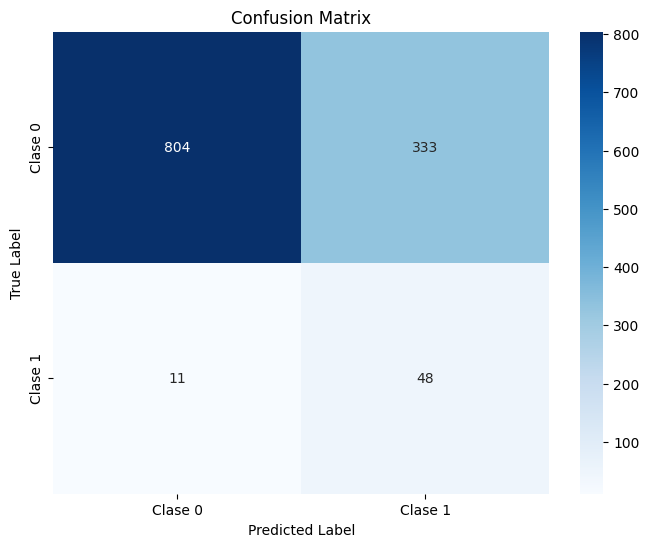

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.99      0.71      0.82      1137
           1       0.13      0.81      0.22        59

    accuracy                           0.71      1196
   macro avg       0.56      0.76      0.52      1196
weighted avg       0.94      0.71      0.79      1196



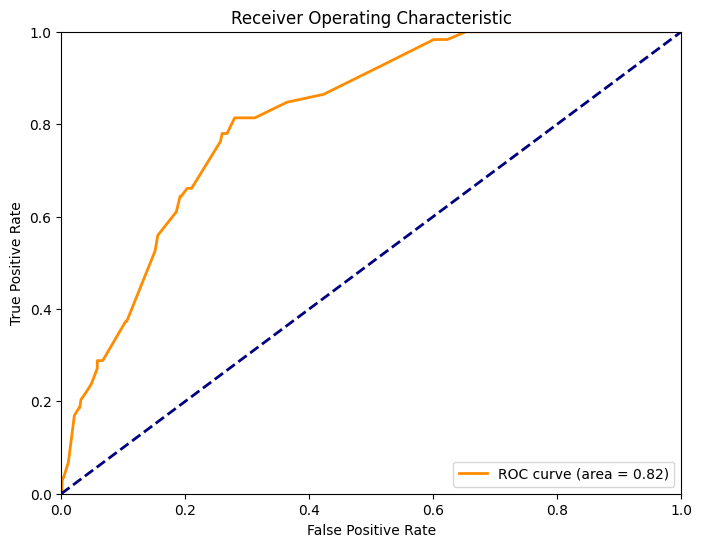

In [53]:
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Clase 0", "Clase 1"], yticklabels=["Clase 0", "Clase 1"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')


print(f"Precisión del modelo: {accuracy_final}")
plt.show()
print("Reporte de clasificación:\n", class_report)

y_prob = final_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [54]:
current_dir = os.getcwd()

parent_dir = os.path.abspath(os.path.join(current_dir, "../.."))
folder_path = 'data'
file_name = 'test_stroke_woe.csv'

file_path = os.path.join(parent_dir, folder_path, file_name)

df_test = pd.read_csv(file_path)

In [55]:
# Separar las características y la variable objetivo del conjunto de test
X_test_new = df_test.drop(['stroke'], axis=1).astype(int)
y_test_new = df_test['stroke']

# Predecir con el modelo final
y_pred_test_new = final_model.predict(X_test_new)
accuracy_test_new = accuracy_score(y_test_new, y_pred_test_new)

# Evaluar el modelo
conf_matrix_test_new = confusion_matrix(y_test_new, y_pred_test_new)
class_report_test_new = classification_report(y_test_new, y_pred_test_new)

# Mostrar resultados
print(f"Precisión del modelo en el conjunto de test: {accuracy_test_new}")
print("Matriz de confusión:\n", conf_matrix_test_new)
print("Reporte de clasificación:\n", class_report_test_new)

Precisión del modelo en el conjunto de test: 0.7141424272818455
Matriz de confusión:
 [[670 273]
 [ 12  42]]
Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.98      0.71      0.82       943
           1       0.13      0.78      0.23        54

    accuracy                           0.71       997
   macro avg       0.56      0.74      0.53       997
weighted avg       0.94      0.71      0.79       997



Precisión del modelo: 0.7141424272818455


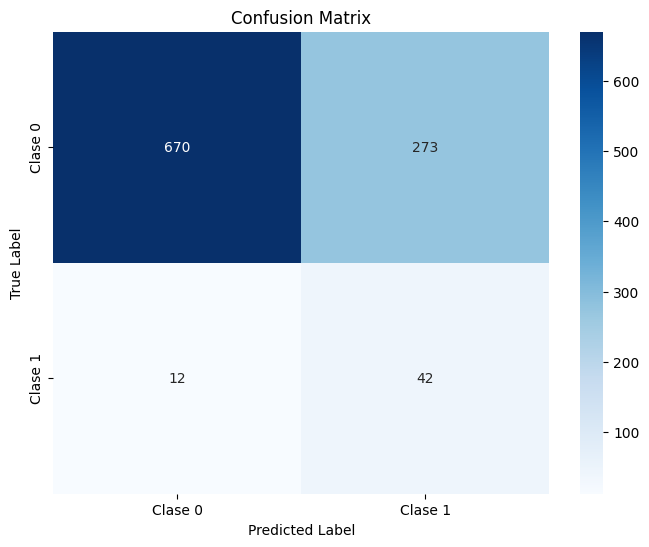

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.98      0.71      0.82       943
           1       0.13      0.78      0.23        54

    accuracy                           0.71       997
   macro avg       0.56      0.74      0.53       997
weighted avg       0.94      0.71      0.79       997



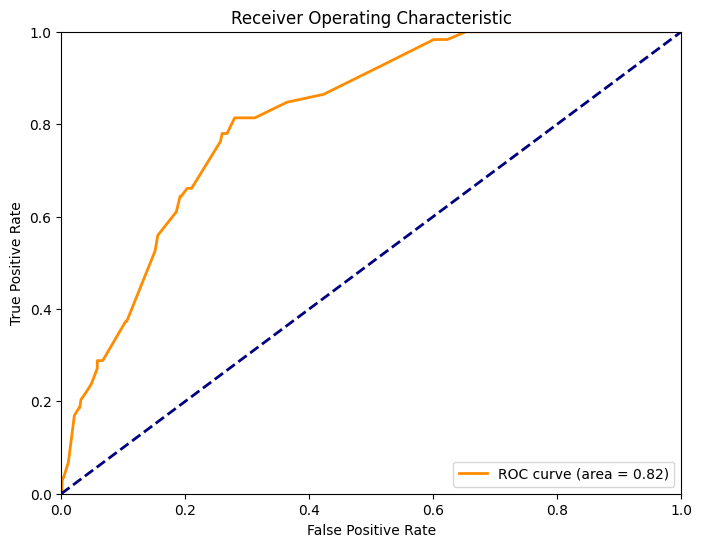

In [56]:
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix_test_new, annot=True, fmt="d", cmap="Blues", xticklabels=["Clase 0", "Clase 1"], yticklabels=["Clase 0", "Clase 1"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')


print(f"Precisión del modelo: {accuracy_test_new}")
plt.show()
print("Reporte de clasificación:\n", class_report_test_new)

y_prob = final_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()